In [1]:
# Common Python libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# For reading in images and image manipulation
import cv2

# For label encoding the target variable
from sklearn.preprocessing import LabelEncoder

# For tensor based operations
from tensorflow.keras.utils import to_categorical, normalize

# For Machine Learning
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# For face detection
from mtcnn.mtcnn import MTCNN

In [3]:
! pip install mtcnn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Reading in the csv file
train = pd.read_csv("train.csv")

# Displaying the first five rows
train.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [3]:
# Total number of unique images
len(train["name"].unique())

4326

In [4]:
# classnames to select
options = ["face_with_mask", "face_no_mask"]

# Select rows that have the classname as either "face_with_mask" or "face_no_mask"
train = train[train["classname"].isin(options)].reset_index(drop=True)
train.sort_values("name", axis=0, inplace=True)

<BarContainer object of 2 artists>

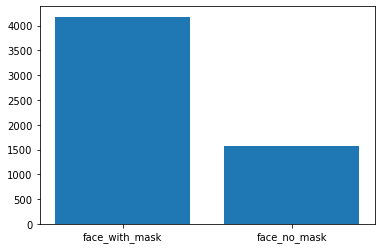

In [5]:
# Plotting a bar plot
x_axis_val = ["face_with_mask", "face_no_mask"]
y_axis_val = train.classname.value_counts()
plt.bar(x_axis_val, y_axis_val)

In [6]:
# Contains images of medical masks
images_file_path = "Medical mask/Medical mask/images/"

# Fetching all the file names in the image directory
image_filenames = os.listdir(images_file_path)

# Printing out the first five image names
print(image_filenames[:5])

['0001.jpg', '0002.png', '0003.jpg', '0004.jpg', '0005.jpg']


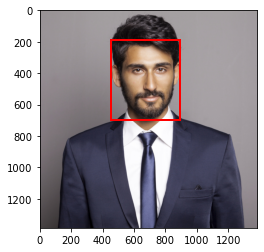

In [7]:
# Getting the full image filepath
sample_image_name = train.iloc[0]["name"]
sample_image_file_path = images_file_path + sample_image_name

# Select rows with the same image name as in the "name" column of the train dataframe
sel_df = train[train["name"] == sample_image_name]

# Convert all of the available "bbox" values into a list
bboxes = sel_df[["x1", "x2", "y1", "y2"]].values.tolist()

# Creating a figure and a sub-plot
fig, ax = plt.subplots()

# Reading in the image as an array
img = plt.imread(sample_image_file_path)

# Showing the image
ax.imshow(img)

# Plotting the bounding boxes
for box in bboxes:

    x1, x2, y1, y2 = box

    # x and y co-ordinates
    xy = (x1, x2)

    # Width of box
    width = y1 - x1

    # Height of box
    height = y2 - x2

    rect = patches.Rectangle(
        xy,
        width,
        height,
        linewidth=2,
        edgecolor="r",
        facecolor="none",
    )

    ax.add_patch(rect)

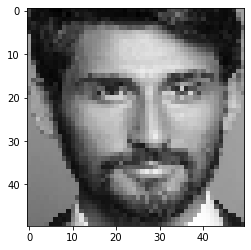

In [8]:
img_size = 50
data = []

for index, row in train.iterrows():

    # Single row
    name, x1, x2, y1, y2, classname = row.values

    # Full file path
    full_file_path = images_file_path + name

    # Reading in the image array as a grayscale image
    img_array = cv2.imread(full_file_path, cv2.IMREAD_GRAYSCALE)

    # Selecting the portion covered by the bounding box
    crop_image = img_array[x2:y2, x1:y1]

    # Resizing the image
    new_img_array = cv2.resize(crop_image, (img_size, img_size))

    # Appending the arrays into a data variable along with bounding box
    data.append([new_img_array, classname])

# Plotting one of the images after pre-processing
plt.imshow(data[0][0], cmap="gray")

In [9]:
# Initializing an empty list for features (independent variables)
x = []

# Initializing an empty list for labels (dependent variable)
y = []

for features, labels in data:
    x.append(features)
    y.append(labels)

In [10]:
# Reshaping the feature array (Number of images, IMG_SIZE, IMG_SIZE, Color depth)
x = np.array(x).reshape(-1, 50, 50, 1)

# Normalizing
x = normalize(x, axis=1)

# Label encoding y
lbl = LabelEncoder()
y = lbl.fit_transform(y)

# Converting it into a categorical variable
y = to_categorical(y)

In [11]:
input_img_shape = x.shape[1:]
print(input_img_shape)

(50, 50, 1)


In [12]:
# Initializing a sequential keras model
model = Sequential()

# Adding a 2D convolution layer
model.add(
    Conv2D(
        filters=100,
        kernel_size=(3, 3),
        use_bias=True,
        input_shape=input_img_shape,
        activation="relu",
        strides=2,
    )
)

# Adding a max-pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Adding a 2D convolution layer - Output Shape = 10 x 10 x 64
model.add(Conv2D(filters=64, kernel_size=(3, 3), use_bias=True, activation="relu"))

# Adding a max-pooling layer - Output Shape = 5 x 5 x 64
model.add(MaxPooling2D(pool_size=(2, 2)))

# Adding a flatten layer - Output Shape = 5 x 5 x 64 = 1600
model.add(Flatten())

# Adding a dense layer - Output Shape = 50
model.add(Dense(50, activation="relu"))

# Adding a dropout
model.add(Dropout(0.2))

# Adding a dense layer with softmax activation
model.add(Dense(2, activation="softmax"))

# Printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 100)       1000      
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 100)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        57664     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 50)                8

In [13]:
import tensorflow as tf

# Define the learning rate schedule using the ExponentialDecay function
initial_lr = 1e-3
decay_rate = 1e-5
decay_steps = 1000  # Adjust this based on your dataset size and training configuration
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps, decay_rate)

# Initializing an Adam optimizer with the learning rate schedule
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Configuring the model for training
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

# Training the model
model.fit(x, y, epochs=30, batch_size=5)


Epoch 1/30
1150/1150 [==============================] - 14s 11ms/step - loss: 0.5855 - accuracy: 0.7269
Epoch 2/30
1150/1150 [==============================] - 12s 10ms/step - loss: 0.5824 - accuracy: 0.7271
Epoch 3/30
1150/1150 [==============================] - 12s 10ms/step - loss: 0.5811 - accuracy: 0.7271
Epoch 4/30
1150/1150 [==============================] - 12s 10ms/step - loss: 0.5831 - accuracy: 0.7271
Epoch 5/30
1150/1150 [==============================] - 12s 11ms/step - loss: 0.5826 - accuracy: 0.7271
Epoch 6/30
1150/1150 [==============================] - 13s 11ms/step - loss: 0.5835 - accuracy: 0.7271
Epoch 7/30
1150/1150 [==============================] - 12s 11ms/step - loss: 0.5823 - accuracy: 0.7271
Epoch 8/30
1150/1150 [==============================] - 12s 11ms/step - loss: 0.5833 - accuracy: 0.7271
Epoch 9/30
1150/1150 [==============================] - 12s 11ms/step - loss: 0.5839 - accuracy: 0.7271
Epoch 10/30
1150/1150 [==============================] - 12s 11m

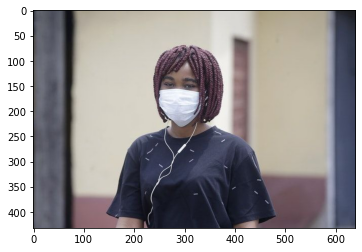

In [21]:
# Image file path for sample image
test_image_file_path = "0048.jpg"

# Loading in the image
img = plt.imread(test_image_file_path)

# Showing the image
plt.imshow(img)

In [22]:
# Initializing the detector
detector = MTCNN()

# Detecting the faces in the image
faces = detector.detect_faces(img)

print(faces)

1/1 [==============================] - 0s 160ms/step
[{'box': [251, 107, 80, 96], 'confidence': 0.9969334602355957, 'keypoints': {'left_eye': (272, 139), 'right_eye': (313, 139), 'nose': (291, 161), 'mouth_left': (274, 177), 'mouth_right': (308, 180)}}]


1/1 [==============================] - 0s 148ms/step


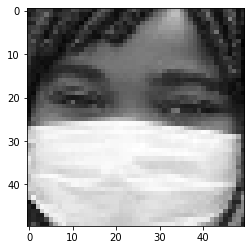

In [23]:
# Reading in the image as a grayscale image
img_array = cv2.imread(test_image_file_path, cv2.IMREAD_GRAYSCALE)

# Initializing the detector
detector = MTCNN()

# Detecting the faces in the image
faces = detector.detect_faces(img)

# Getting the values for bounding box
x1, x2, width, height = faces[0]["box"]

# Selecting the portion covered by the bounding box
crop_image = img_array[x2 : x2 + height, x1 : x1 + width]

# Resizing the image
new_img_array = cv2.resize(crop_image, (img_size, img_size))

# Plotting the image
plt.imshow(new_img_array, cmap="gray")

In [17]:
# Reshaping the image
x = new_img_array.reshape(-1, 50, 50, 1)

# Normalizing
x = normalize(x, axis=1)

In [18]:
x.shape

(1, 50, 50, 1)

In [19]:
prediction = model.predict(x)
print(prediction)

1/1 [==============================] - 0s 123ms/step
[[0.21928735 0.7807126 ]]


In [20]:
np.argmax(prediction)

1